# Synchrotron Radiation 

### By: Pablo Sotomayor

---

A wide variety of astrophysical sources exhibit magnetic fields and relativistic charged particles, both ingredients for the emission of synchrotron radiation. Some typical values are:

| | Source  | Magnetic field [G]    | 
|---:|:-------------|:-----------|
| 1 | Interstellar medium  | $10^{-6}$       |
| 2 | Stellar atmosphere  | $1$    |
| 3 | Supermassive black hole  | $10^{4}$    | 
| 4 | White dwarf  | $10^{8}$   |
| 5 | Neutron star  | $10^{12}$    |
| 6 | Crab nebula  | $10^{-3}$    |

In this notebook we will learn how to numerically obtain quantitative estimates of synchrotron radiation output for single particles and populations of non-thermal particles.

In [208]:
# Getting libraries

import numpy as np
from scipy.special import kv
from scipy.integrate import simps
from math import pi, isclose
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings("ignore")
%matplotlib inline

In [77]:
# Physical parameters
# Units: cgs

lightVelocity = 29979245800
thomsonCrossSection = 6.6524e-25
fineStructureConstant = 7.297352568e-3
electronMass = 9.1094e-28
protonMass = 1.6726e-24
elementalCharge = 4.8032e-10
erg2ev = 6.242e11
ev2erg = 1/erg2ev
solarMass = 1.989e33
solarRadius = 6.96e10
gravitationalConstant = 6.6743e-8
planckConstant = 6.6261e-27
boltzmannConstant = 1.3807e-16
barn2cm = 1e-24
pc2cm = 3.086e18
lightday2pc = lightVelocity*24*3600/pc2cm
yr2sec = 3.156e7
solarLuminosity = 3.839e33
astronomicalUnit = 1.496e13
stefanBoltzmannConstant = 5.6704e-5
deg2rad = pi/180
rad2deg = 1/deg2rad

In [78]:
# Function that returns the physical parameters according to the type of particle

def mass(typeParticle):
    if typeParticle == 'electron':
        massParticle = electronMass
    elif typeParticle == 'proton':
        massParticle = protonMass    
    else:
        raise AttributeError('Unknown particle')
    return massParticle

def charge(typeParticle):
    chargeParticle = elementalCharge
    if typeParticle == 'neutron':
        return 0.
    return chargeParticle

def classicalRadius(typeParticle):
    q = charge(typeParticle)
    m = mass(typeParticle)
    c = lightVelocity
    return  q*q/m/c/c

def thomsonCrossSection(typeParticle):    
    return 8.*pi*(classicalRadius(typeParticle)**2)/3

def restEnergy(typeParticle):
    return mass(typeParticle)*c*c

## A single particle

The total power emitted by a charged particle in a source with magnetic field $B$ is:

$$P = \frac{2}{3}r_{\rm cl}^2 c \beta^2 B^{2}\gamma^{2} \sin^2{\alpha}$$

where $r_{\rm cl}$ is the classical radius of the particle, $c$ is the light velocity, $\beta$ is the normalized velocity of the particle ($v/c$), $\gamma$ is the Lorentz factor of the particle, and $\alpha$ is the pitch angle of the particle. If we assume isotropy:

$$<\sin^{2}{\alpha}> = \frac{\int \sin^{3}{\alpha}\,{\rm d}^2 \Omega}{\int \sin^{2}{\alpha}\,{\rm d}^2 \Omega} = \frac{2}{3}$$

Then, the pitch-angle averaged synchrotron power is given by:

$$P = \frac{4}{3}\sigma_{\rm T}c\beta^2 \gamma^2 U_{\rm B}$$

where $\sigma_{\rm T} = 8\pi r_{\rm cl}^2 /3$ is the Thomson cross section, and $U_{\rm B} = B^2 /8 \pi$ is the magnetic energy density in the source.


In general, the timescale of a quantity $A$ can be estimated as $t = A/\dot{A}$, provided that $\dot{A}$ represents continuous change. Thus, the timescale of energy loss of a particle by synchrotron radiation is:

$$t_{\rm syn} = \frac{E}{<P_{\rm syn}>}$$
$$t_{\rm syn} = \frac{\gamma m c^2}{\frac{4}{3}\sigma_{\rm T}c\beta^2 \gamma^2 U_{\rm B}} = \frac{3 m c}{4 \sigma_{\rm T}\beta^2 \gamma U_{\rm B}}$$

We consider scenarios for which $\beta \rightarrow 1$.

In [111]:
# Function that returns the cooling timescale for radiation synchrotron

def coolingTime(magneticField:float, 
                lorentzFactor:float, 
                particle:str, 
                pitchAngle:float=np.arcsin(np.sqrt(2/3)))->float:
    Bmag = magneticField
    LF = lorentzFactor
    rcl = classicalRadius(particle)
    c = lightVelocity
    psyn = (2*c*(rcl*np.sin(pitchAngle)*LF*Bmag)**2)/3        
    tsyn = LF*mass(particle)*c*c/psyn
    return tsyn

**Example 1**: An electron with $\gamma_{\rm e} = 10^{3}$ in a source with $B = 10^4\,{\rm G}$.

In [108]:
B = 1e4
LF = 1e3
time = coolingTime(magneticField=B, lorentzFactor=LF, particle='electron')
print(f"Timescale by syncrotron cooling = {time:0.2e} sec.")

Timescale by syncrotron cooling = 7.74e-03 sec.


**Example 2**: The same for a proton in equal conditions.

In [109]:
time = coolingTime(magneticField=B, lorentzFactor=LF, particle='proton')
print(f"Timescale by synchrotron cooling = {time:0.2e} sec.")

Timescale by synchrotron cooling = 4.79e+07 sec.


The cooling time for the proton is 10 orders of magnitude longer than for the electron. These results are consistent with the expected values. Replacing the constants into the cooling time equation we get:

$$t_{\rm syn,\,e} = \frac{7.74\times 10^{8}}{B^{2} \gamma}\; {\rm sec}$$

$$t_{\rm syn,\,p} = \frac{4.79\times 10^{18}}{B^{2} \gamma}\; {\rm sec}$$

Unlike the non-relativistic case, a charged particle with $\beta \rightarrow 1$ emits synchrotron radiation in a continuous range of frequencies.  The spectrum is cut off for frequencies higher than a certain critical value $\nu_{\rm c}$, which depends on the energy of the particle and its pitch angle. The critical energy $E_{\rm c} = h\nu_{\rm c}$ associated with the synchrotron radiation emitted by a particle with mass $m$, Lorentz factor $\gamma$, in a source with magnetic field $B$, and pitch angle $\alpha$ is:

$$E_{\rm c} = \frac{3 h q B \gamma^2}{4 \pi m c} \sin {\alpha}$$

where we consider isotropy:

$$<\sin {\alpha}> = \frac{\pi}{4}$$

The synchrotron spectrum is the total power emitted per unit of photon energy (or frequency):

$$P_{\rm syn}(E, E_{\rm ph}) = \frac{\sqrt{3} q^{3} B \sin {\alpha}}{m c^2 h} \frac{E_{\rm ph}}{E_{\rm c}} \int_{E_{\rm ph}/E_{\rm c}}^{\infty} K_{5/3} (x) {\rm d}x \qquad [{\rm erg\,s^{-1}\,erg^{-1}}],$$

where $K_{5/3} (x)$ is a Bessel modified function. The power reaches a maximum value at $E_{\rm ph,\,max} \simeq 0.29\,E_{\rm c}$.

In [110]:
# Function that returns the critical energy for radiation synchrotron

def criticalEnergy(magneticField:float, 
                   lorentzFactor:float, 
                   particle:str):
    Bmag = magneticField
    LF = lorentzFactor      
    hp = planckConstant
    Ec = 3*hp*charge(particle)*Bmag*(LF**2)
    c = lightVelocity
    Ec /= (16*c*mass(particle))
    return Ec

**Example 3**: Calculate the expected maximum energy of synchrotron photons emitted by an electron with $\gamma = 10^{3}$ in the Crab Nebula ($B = 10^{-3}\,{\rm G}$).

In [123]:
B = 1e-3
LF = 1e3
Ec = criticalEnergy(magneticField=B, lorentzFactor=LF, particle='electron')
print(f"Critical energy = {0.29*Ec*erg2ev:0.2e} eV (radio frequencies).")

Critical energy = 3.96e-06 eV (radio frequencies).


**Example 4**: Considering Example 3, calculate the emitted synchrotron power in photons with $E_{\rm ph} = E_{\rm ph,\,max}$. In order to obtain the units of ${\rm erg\,s^{-1}}$, the required power is estimated as $P_{\rm syn}(E_{\rm ph})\times E_{\rm ph}$.

In [125]:
# Function that returns the specific power emitted by  synchrotron radiation

def singleParticlePower(magneticField:float, 
                        lorentzFactor:float, 
                        particle:str, 
                        photonEnergy:float):        
    #---------------------------------------------------------------------
    # Photon energy must be lower than particle energy.
    # t = photon energy/particle energy
    # If t < 1 then
    #   The power is calculated
    # else
    #   Power = 0
    #---------------------------------------------------------------------
    Bmag = magneticField
    Eph = photonEnergy
    LF = lorentzFactor
    c = lightVelocity
    t = Eph/LF/mass(particle)/c/c                 
    Ec = criticalEnergy(magneticField, lorentzFactor, particle)         
    if type(t) is float or t.size == 1:
        if t < 1:
            x = Eph/Ec/(1-t)
            f = 1.85*(1-t)*(x**(1/3))*np.exp(-x)
        else:
            return 0
    else:
        f = np.zeros(len(t))
        for i, t_ in enumerate(t):
            if t_ < 1:
                x = Eph/Ec[i]/(1 - t_)
                f[i] = 1.85*(1-t_)*(x**(1/3))*np.exp(-x)
            else:
                f[i] = 0
    hp = planckConstant
    P = (charge(particle)**3)*Bmag*pi*f*np.sqrt(3)
    P = P/4/mass(particle)/c/c/hp        
    return P 

In [131]:
B = 1e-3
LF = 1e3
Eph = 1.36e-5 *ev2erg
Psyn = singleParticlePower(B, LF, 'electron', Eph)
print(f"Emitted synchrotron power = {Psyn*Eph:0.2e} erg/s.")

Emitted synchrotron power = 4.13e-16 erg/s.


**Example 5**: Plot the synchrotron spectrum emitted by an electron with $\gamma = 5$ in a source with magnetic field $B=10^{4}\,{\rm G}.$

In [138]:
# Array of photon energies

Ephmin = 1e-10 *ev2erg
Ephmax = 1e6 *ev2erg
EphGrid = 100

arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), EphGrid)

# Array of synchrotron power

B = 1e4
LF = 5
arrPph_LF5 = np.zeros(EphGrid)

for i in range(EphGrid):
    arrPph_LF5[i] = singleParticlePower(B, LF, 'electron', arrEph[i])

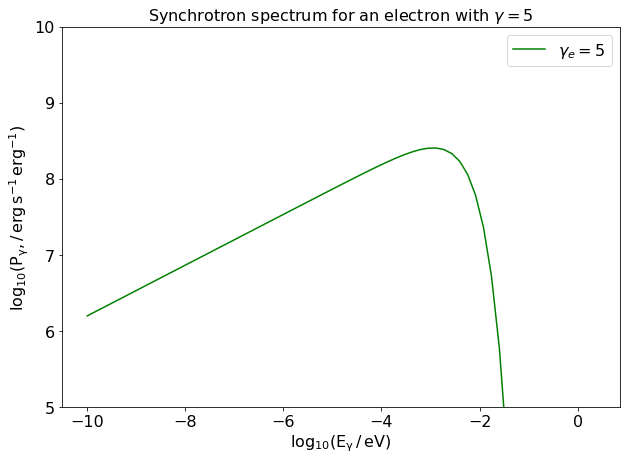

In [144]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPph_LF5), ls = "-", c='green', label='$\gamma_{e} = 5$')
plt.xlabel(r"$\log_{10} ({\rm E_{\gamma}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm P_{\gamma},/\,erg\,s^{-1}\,erg^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(5,10)
plt.legend(fontsize=16)
plt.title(r'Synchrotron spectrum for an electron with $\gamma = 5$', fontsize=16)
plt.show()

**Example 6**: Plot in the graph above the spectrum emitted by an electron with $\gamma = 500$.

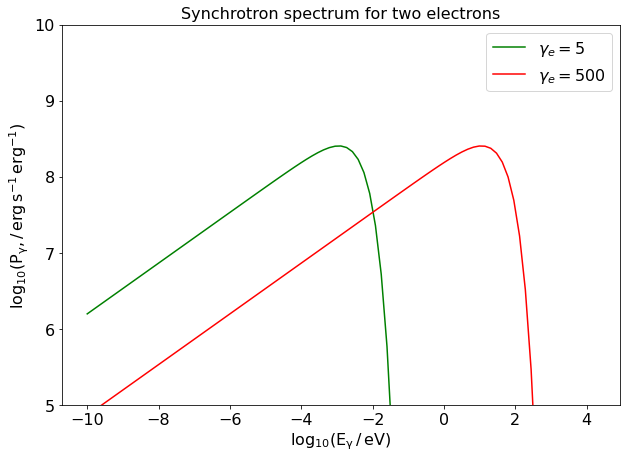

In [145]:
# Array of synchrotron power

B = 1e4
LF = 500
arrPph_LF500 = np.zeros(EphGrid)

for i in range(EphGrid):
    arrPph_LF500[i] = singleParticlePower(B, LF, 'electron', arrEph[i])
    
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPph_LF5), ls = "-", c='green', label='$\gamma_{e} = 5$')
plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPph_LF500), ls = "-", c='red', label='$\gamma_{e} = 500$')
plt.xlabel(r"$\log_{10} ({\rm E_{\gamma}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm P_{\gamma},/\,erg\,s^{-1}\,erg^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(5,10)
plt.legend(fontsize=16)
plt.title(r'Synchrotron spectrum for two electrons', fontsize=16)
plt.show()

**Example 7**: Same as Example 6, but for protons.

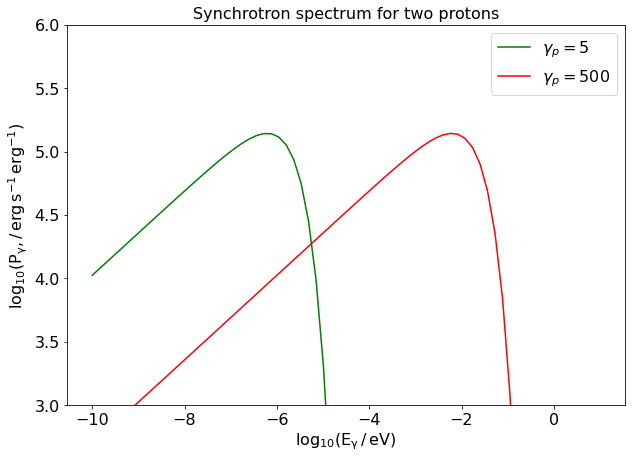

In [148]:
Ephmin = 1e-10 *ev2erg
Ephmax = 1e6 *ev2erg
EphGrid = 100

arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), EphGrid)

B = 1e4
LF1 = 5
LF2 = 500

arrPph_LF5 = np.zeros(EphGrid)
arrPph_LF500 = np.zeros(EphGrid)
for i in range(EphGrid):
    arrPph_LF5[i] = singleParticlePower(B, LF1, 'proton', arrEph[i])
    arrPph_LF500[i] = singleParticlePower(B, LF2, 'proton', arrEph[i])
    
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPph_LF5), ls = "-", c='green', label='$\gamma_{p} = 5$')
plt.plot(np.log10(arrEph*erg2ev),np.log10(arrPph_LF500), ls = "-", c='red', label='$\gamma_{p} = 500$')
plt.xlabel(r"$\log_{10} ({\rm E_{\gamma}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm P_{\gamma},/\,erg\,s^{-1}\,erg^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(3,6)
plt.legend(fontsize=16)
plt.title(r'Synchrotron spectrum for two protons', fontsize=16)
plt.show()

## Population of non-thermal particles

We consider a distribution of relativistic particles that follows a power-law function for their density:

$$ N(E) {\rm d}E = K E^{-p} {\rm d}E \qquad [{\rm erg^{-1}\,cm^{-3}}]$$

The synchrotron spectrum emitted by the particle distribution is given by:

$$\epsilon_{\rm syn}(E_{\rm ph}) = \int_{E_{\rm min}}^{E_{\rm max}} {\rm d}E\, N(E) P_{\rm syn}(E, E_{\rm ph}) \qquad [{\rm erg\,s^{-1}\,cm^{-3} \,erg^{-1}}]$$

The synchrotron emissivity is calculated from the volumetric power emitted as:

$$j_{\rm syn}(E_{\rm ph}) = \frac{\epsilon_{\rm syn}(E_{\rm syn})}{4\pi} \qquad [{\rm erg\,s^{-1}\,cm^{-3}\,sr^{-1} \,erg^{-1}}]$$

**Example 8**: Plot the spectral energy distribution (SED: photon energy vs photon luminosity) of synchrotron radiation emitted by a population of electrons in a source with magnetic field $B=10^{4}\,{\rm G}$. Consider that the electrons are injected following a power law $Q=Q_0 E^{-p}$. The spectral index is $p=2$, the minimum energy $E_{\rm min} = 2m_{\rm e}c^{2}$, and the total injected power is $L_{\rm inj} = 10^{38}\,{\rm erg\,s^{-1}}$. The typical timescale for the electron escape is $T_{\rm esc} = 10\,{\rm s}$. We model the source as a sphere of radius 0.1 pc. Neglect synchrotron self-absorption effects.

First: we propose maximum fiducial energy and set the array of energies $E_{\rm max} = 10\,{\rm TeV}$.

In [312]:
me = electronMass
c = lightVelocity

Emin = 2*me*c*c                 # minimum energy
Emax = 10*1e12 *ev2erg          # maximum energy
Egrid = 100                     # grid size

arrE = np.logspace(np.log10(Emin), np.log10(Emax), Egrid)

Second: we calculate the injection function for those energies.

$$ L_{\rm inj} = \int {\rm d}V \int_{E_{\rm min}}^{E_{\rm max}} {\rm d}E E Q(E) $$


In [313]:
p = 2                           # spectral index
Linj = 1e36                     # power in particle injection
r = 0.1*pc2cm                   # hotspot radius
volume = 4.*pi*r**3 /3
integral = simps(arrE**(-p+1),arrE)
Q0 = Linj/integral/volume
arrQ = Q0*arrE**(-p)            # in units of erg^-1 s^-1 cm^-3

Third: we calculate the cooling time for each energy value of the electrons.

In [314]:
B = 1e4

arrTcool = coolingTime(magneticField=B, lorentzFactor=arrE/me/c/c, particle='electron')

Fourth: we calculate the acceleration time for each energy value of the electrons.

In [315]:
eta = 1e-2
qe = elementalCharge

arrTacc = 1/(eta*c*B*qe/(arrE))

Fifth: we calculate the escape time for each energy value of the electrons.

In [316]:
Tesc = 0.1

arrTesc = Tesc*np.ones(Egrid)

Sixth: We determine the maximum energy of the electrons from plotting the timescales of cooling, escape, and acceleration.

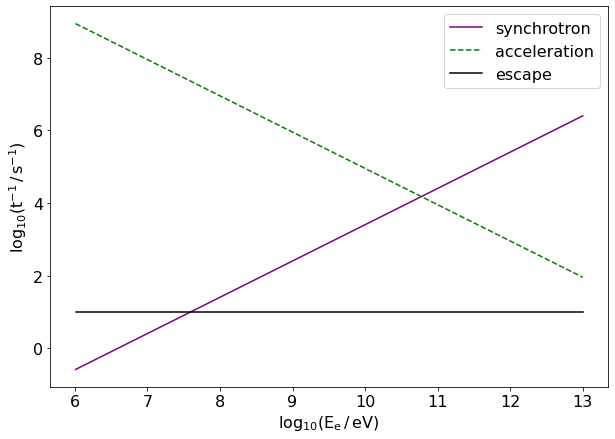

In [317]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTcool),c='purple', label='synchrotron')
plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTacc),c='green', ls='--', label='acceleration')
plt.plot(np.log10(arrE*erg2ev), -np.log10(arrTesc),c='black', label='escape')
plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm t^{-1}\,/\,s^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

We see that the maximum energy of the electrons is determined by equating the time scale of synchrotron radiation cooling and that of acceleration.

In [318]:
# We estimate the maximum energy of electrons by calculating the energy at which the difference between the cooling and acceleration timescales is closest to zero.

index,  = np.where(np.abs(arrTcool - arrTacc) == np.abs(arrTcool - arrTacc).min())

Emax = arrE[int(index)]

print(f"Maximum energy of electrons = {Emax*erg2ev:0.3e} eV.")

Maximum energy of electrons = 5.501e+10 eV.


Seventh: We recalculate the energy arrangements, time scales, and injection, considering the new maximum energy.

In [319]:
arrE = np.logspace(np.log10(Emin), np.log10(Emax), Egrid)

integral = simps(arrE**(-p+1),arrE)
Q0 = Linj/integral/volume
arrQ = Q0*arrE**(-p)

arrTcool = coolingTime(magneticField=B, lorentzFactor=arrE/me/c/c, particle='electron')
arrTacc = 1/(eta*c*B*qe/(arrE))
arrTesc = Tesc*np.ones(Egrid)

Eighth: We calculate the distribution of particles in steady state by solving the transport equation

In [320]:
# Auxiliary function that returns limits of intervals in which we divide the range of integration

def getSubArrays(arr:np.ndarray, 
                 tol=1e-6):    
    #---------------------------------------------------------------------
    # Getting the sub arrays
    # array 1: [Emin : 10Emin]
    # array 2: [10Emin : 100Emin]
    # ...
    # array N = [10^(N-1) Emin : 10^N Emin]
    # if 10^N Emin < Emax then one more array is added 
    #   interval N+1 = [10^N Emin : Emax]        
    #---------------------------------------------------------------------        
    xmin = arr[0]
    xmax = arr[-1]
    nArrays = int(np.log10(xmax/xmin))
    key = abs(xmax - xmin*10**nArrays) < tol*xmax 
    if not key:
        nArrays += 1
    #---------------------------------------------------------------------            
    # Setting the arrays of minimum and maximum energy
    # K sub arrays (K = N or K = N+1)
    # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
    # arrEmax = [Emax, 10Emax, 100Emax, ..., min(10^K Emin, Emax)]
    #---------------------------------------------------------------------
    arrMin = np.ones(nArrays) 
    arrMax = np.ones(nArrays)
    for i in range(nArrays):
        arrMin[i] = xmin*10**(i)
        arrMax[i] = xmin*10**(i+1)    
    if not key:            
        arrMax[-1] = xmax
    return arrMin, arrMax 

In [321]:
# Function that returns the particle distribution

from math import exp

def transportEquation(
    particleEnergy:float,
    arrEnergy:np.array,
    arrInjection:np.array,
    arrCoolingTime:np.array,
    escapeTime=None,
    escapeEnergyDependent:bool=False,
    timeDependent:bool=False)->np.array:
       
    if timeDependent is False:
        #---------------------------------------------------------------------
        # Getting Emin and Emax for the integration
        #---------------------------------------------------------------------
        Emin = particleEnergy
        Emax = arrEnergy[-1]
        if Emax < Emin:
            errorString = 'The particle energy must be lower than the \
                maximum energy'
            raise ValueError(errorString)
        if isclose(Emin,Emax):
            return 0
        #---------------------------------------------------------------------
        # Getting the arrays of E and Q for the integration
        #---------------------------------------------------------------------
        arrQ = np.delete(arrInjection,np.where(arrEnergy < Emin))        
        arrE = np.delete(arrEnergy,np.where(arrEnergy < Emin))        
        #---------------------------------------------------------------------            
        # Setting the arrays of minimum and maximum energy 
        # K intervals 
        # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
        # arrEmax = [Emax, 10Emax, 100Emax, ..., Emax]
        #---------------------------------------------------------------------
        arrEmin = getSubArrays(arrE)[0]
        arrEmax = getSubArrays(arrE)[1]
        nArrays = len(arrEmin) 
        partialIntegral = np.ones(nArrays)         
        #---------------------------------------------------------------------
        # Distributing the integral in nArrays partial integrals
        # integral = sum(partialIntegral)
        #---------------------------------------------------------------------
        for i in range(nArrays):
            #-----------------------------------------------------------------
            # Solving the i-th integral
            # arrE_ for E in [arrEmin[i]:arrEmax[i]]
            # arrQ_ for Q in [Q(arrEmin[i]):Q(arrEmax[i])]
            # IF_ for IF in [IF(arrEmin[i]):IF(arrEmax[i])]
            #-----------------------------------------------------------------
            arrE_ = np.linspace(arrEmin[i],arrEmax[i],10)
            arrQ_ = np.interp(arrE_,arrE,arrQ)           
            IF_ = np.zeros(10)                            
            for j in range(10):
                arrE__ = np.linspace(particleEnergy,arrE_[j],10)
                arrTcool__ = np.interp(arrE__,arrEnergy,arrCoolingTime)               
                IF_[j] = integratingFactor(arrE__,arrTcool__,escapeTime,
                                           escapeEnergyDependent)                
            partialIntegral[i] = simps(arrQ_*IF_,arrE_)
        particleTcool = np.interp(particleEnergy,arrEnergy,arrCoolingTime)
        particleDensity = particleTcool*sum(partialIntegral)/particleEnergy
    #=========================================================================
    # Non-stationary case
    #=========================================================================    
    else:
        raise NotImplementedError
    return particleDensity

def integratingFactor(
    arrEnergy:np.array,
    arrCoolingTime:np.array,
    escapeTime,
    keyEscape:bool):

    #------------------------------------------------------------------------
    # Getting Emin and Emax for the integration
    #------------------------------------------------------------------------
    Emin = arrEnergy[0]
    Emax = arrEnergy[-1]
    if Emax < Emin:
        raise ValueError('Minimum energy must be lower than the maximum energy')
    if isclose(Emin,Emax):        
        return 1
    #------------------------------------------------------------------------
    # Getting sub-intervals for the integration
    #------------------------------------------------------------------------
    arrEmin = getSubArrays([Emin,Emax])[0]
    arrEmax = getSubArrays([Emin,Emax])[1]
    nArrays = len(arrEmin)
    partialIntegral = np.zeros(nArrays)
    #------------------------------------------------------------------------
    # Distributing the integral in nArrays partial integrals
    # integral = sum(partialIntegral)
    #------------------------------------------------------------------------
    for i in range(nArrays):
        #--------------------------------------------------------------------
        # For the ith partial integral we define the array of energies arrE,
        # the array of cooling times arrTcool, and the array of the escape 
        # times arrTesc, if applicable.
        #--------------------------------------------------------------------
        arrE = np.linspace(arrEmin[i],arrEmax[i],10)        
        arrTcool = np.interp(arrE,arrEnergy,arrCoolingTime)        
        if keyEscape is False:
            #----------------------------------------------------------------
            # When the escape does not depend on the energy of the particles, 
            # the integral depends only on the cooling of the particles
            #----------------------------------------------------------------
            partialIntegral[i] = simps(arrTcool/arrE,arrE)
        else:           
            partialIntegral[i] = simps(arrTcool/arrE/escapeTime,arrE)
    integral = sum(partialIntegral)    
    if keyEscape is False and escapeTime is not None:
        integral /= escapeTime
    return np.exp(-integral)

In [322]:
arrN_onlyCooling = np.zeros(Egrid)

for i in range(Egrid):        
    arrN_onlyCooling[i] =transportEquation(particleEnergy=arrE[i],
                                           arrEnergy=arrE,
                                           arrInjection=arrQ,
                                           arrCoolingTime=arrTcool,
                                           escapeTime=None,
                                           escapeEnergyDependent=False)


arrN_onlyEscape = arrQ*Tesc

arrN = 1./(1./arrN_onlyCooling + 1./arrN_onlyEscape)     # in units of erg^-1 cm^-3

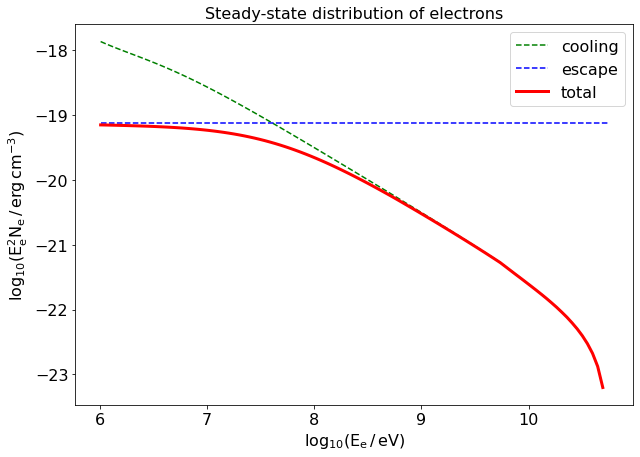

In [323]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrN_onlyCooling), ls = "--", c='green', label='cooling')
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrN_onlyEscape), ls = "--", c='blue', label='escape')
plt.plot(np.log10(arrE*erg2ev),np.log10(arrE*arrE*arrN), lw=3, c='red', label='total')
plt.xlabel(r"$\log_{10} ({\rm E_{e}\,/\,eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} ({\rm E_{e}^2 N_{e}\,/\,erg\,cm^{-3}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title("Steady-state distribution of electrons", fontsize=16)
plt.show()

Ninth: From the previously calculated distribution, determine the synchrotron spectral emissivity. For this, an array of energies for the photons must be defined.

In [324]:
# We use the Gauss-Legendre quadrature method

nSynEmi = 10

def getNodesGL(points:int):
    return np.polynomial.legendre.leggauss(points) 

In [325]:
# Synchrotron emissivity of a particle distribution

def emissivity(arrLorentzFactor:np.ndarray, 
               arrDensity:np.ndarray, 
               magneticField:float, 
               particle:str, 
               photonEnergy:float):
    '''
    Calculate the specific power per unit volume for a distribution of 
    nonthermal particles.

    Returns
    -------
    specificPower : float
        [specificPower] = erg s^-1 cm^-3 erg^-1

    '''                
    #---------------------------------------------------------------------            
    # Setting the arrays of minimum and maximum energy
    # K sub arrays  for the calculations
    # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
    # arrEmax = [Emax, 10Emax, 100Emax, ..., Emax]
    #---------------------------------------------------------------------
    LF = arrLorentzFactor
    c = lightVelocity
    arrEnergy = LF*mass(particle)*c*c    
    arrPsyn = singleParticlePower(magneticField, LF, particle, photonEnergy)
    arrEmin, arrEmax = getSubArrays(arrEnergy)
    nArrays = len(arrEmin)                
    #---------------------------------------------------------------------
    # Getting the specific emissivity
    # partialEmissivity[i] = Emissivity between arrEmin[i], arrEmax[i]
    #---------------------------------------------------------------------
    partialEmissivity = np.empty(nArrays)        
    arrXgl, arrWgl = getNodesGL(nSynEmi)
    for i in range(nArrays):
        #-----------------------------------------------------------------
        # arrE = [arrEmin[i]:arrEmax[i]]
        # arrN = N(arrE)
        # arrP = single particle power for arrE
        #-----------------------------------------------------------------
        arrE = 0.5*(arrEmax[i]-arrEmin[i])*arrXgl + 0.5*\
          (arrEmax[i]+arrEmin[i])              
        arrN = np.interp(arrE,arrEnergy,arrDensity)    
        arrP = np.interp(arrE,arrEnergy,arrPsyn)            
        partialEmissivity[i] = 0.5*(arrEmax[i]-arrEmin[i])*\
            sum(arrN*arrP*arrWgl)         
    specificPower = sum(partialEmissivity)
    return specificPower/4./pi

In [326]:
# Array of photon energies

Ephmin = 1e-10 *ev2erg
Ephmax = 1e10 *ev2erg
EphGrid = 100

arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), EphGrid)

# Spectral emissivity

arrPsyn = np.zeros(EphGrid)
for i in range(EphGrid):
    arrPsyn[i] = emissivity(arrLorentzFactor=arrE/me/c/c,
                            arrDensity=arrN,
                            magneticField=B,
                            particle='electron',
                            photonEnergy=arrEph[i])


Tenth: The spectral luminosity is calculated and the SED is plotted.

$$L_{\rm syn} = \int {\rm d}V \int {\rm d}\Omega\, j_{\rm syn}$$

In the one-zone model:

$$L_{\rm syn} \approx 4\pi V j_{\rm syn}$$

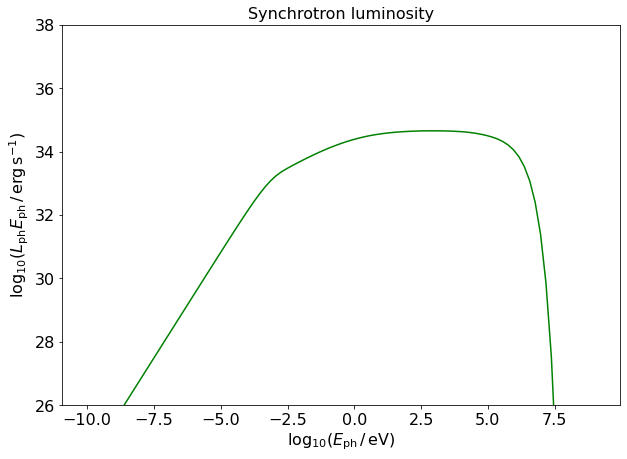

In [327]:
plt.figure(figsize=(10,7))
plt.plot(np.log10(arrEph*erg2ev),np.log10(4*pi*arrEph*arrPsyn*volume), ls = "-", c='green', label='')
plt.xlabel(r"$\log_{10} (E_{\rm ph}\,/\,{\rm eV})$", fontsize=16)
plt.ylabel(r"$\log_{10} (L_{\rm ph}E_{\rm ph}\,/\,{\rm erg\,s^{-1}})$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Synchrotron luminosity", fontsize=16)
plt.ylim(26,38)
plt.show()

### References

1. Notes on Introduction to Relativistic Astrophysics by **Gustavo E. Romero**.
2. Radiative Processes in Astrophysics by **George B. Rybicki** and Alan P. Lightman.
3. Radiative Processes in High Energy Astrophysics by **Gabriele Ghisellini**.